In [6]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use("seaborn")

import sys
sys.path.append("..")
from model.state_space_model import KalmanFilter

from datetime import date
import yfinance as yf

## Local Linear Trend Model with the Kalman Filter
The one-state local linear trend model is expressed as:

$$
\begin{align*}
  v_t &= \mu_t +\epsilon_t \qquad &\epsilon_t \sim N(0,\sigma_{\epsilon_t}^2)\\
  \mu_{t+1} &= \mu_t +\eta_t \qquad &\eta_t \sim N(0,\sigma_{\eta_t}^2)\\
\end{align*}  
$$

where $\epsilon_t$ and $\eta_t$ are assumed random indepedent Normal processes. 

In [16]:
ff_data = pd.read_excel("../data/25_Portfolios_ME_Prior_12.xlsx", sheet_name=[0, 1], header=0, index_col=0)[1] / 100
ff_data.index = pd.date_range(start='07/1963', end='03/2021', freq='m')
ff_data.head()

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-31,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027
1963-08-31,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025
1963-09-30,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027
1963-10-31,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029
1963-11-30,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027


In [13]:
p25_data = pd.read_excel("../data/25_Portfolios_ME_Prior_12.xlsx", sheet_name=[0, 1], header=0, index_col=0)[0]
p25_data.index = pd.date_range(start='01/1927', end='03/2021', freq='m')
p25_data.head()

,SMALL LoPRIOR,ME1 PRIOR2,ME1 PRIOR3,ME1 PRIOR4,SMALL HiPRIOR,ME2 PRIOR1,ME2 PRIOR2,ME2 PRIOR3,ME2 PRIOR4,ME2 PRIOR5,...,ME4 PRIOR1,ME4 PRIOR2,ME4 PRIOR3,ME4 PRIOR4,ME4 PRIOR5,BIG LoPRIOR,ME5 PRIOR2,ME5 PRIOR3,ME5 PRIOR4,BIG HiPRIOR
1927-01-31,-1.78,2.73,4.16,3.22,-4.95,-3.13,10.14,-0.45,1.68,1.44,...,-2.76,2.82,-0.43,2.10,2.87,-6.16,-1.12,0.32,0.38,-0.83
1927-02-28,6.68,5.68,6.34,7.87,8.52,4.92,7.54,5.50,7.21,5.88,...,7.78,13.48,3.52,4.00,5.07,5.42,4.64,3.87,2.87,5.51
1927-03-31,-3.80,2.97,-4.28,-3.70,-1.16,-4.07,-4.81,-0.35,0.28,-0.21,...,-8.72,-5.03,-1.32,-0.33,2.25,3.85,-4.39,-1.41,1.82,3.47
1927-04-30,1.17,-0.75,0.17,7.44,-7.30,-0.73,1.04,-2.07,3.67,7.36,...,-0.60,-2.80,0.81,0.14,1.12,-99.99,-2.00,0.82,0.56,4.11
1927-05-31,3.67,11.70,1.77,12.86,21.88,0.10,3.59,12.66,4.22,6.10,...,4.65,4.09,3.97,8.16,9.68,5.32,3.32,5.80,4.97,6.91


In [17]:
df_corner = p25_data[['SMALL LoPRIOR', 'SMALL HiPRIOR', 'BIG LoPRIOR', 'BIG HiPRIOR']] / 100
df_corner = pd.concat([df_corner, ff_data], join='inner', axis=1)
df_corner

,SMALL LoPRIOR,SMALL HiPRIOR,BIG LoPRIOR,BIG HiPRIOR,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-31,-0.0019,-0.0051,-0.0139,-0.0007,-0.0039,-0.0045,-0.0094,0.0066,-0.0115,0.0027
1963-08-31,0.0198,0.0583,0.0592,0.0712,0.0507,-0.0082,0.0182,0.0040,-0.0040,0.0025
1963-09-30,-0.0098,0.0043,-0.0228,-0.0262,-0.0157,-0.0048,0.0017,-0.0076,0.0024,0.0027
1963-10-31,-0.0066,0.0281,0.0256,0.0851,0.0253,-0.0130,-0.0004,0.0275,-0.0224,0.0029
1963-11-30,-0.0208,-0.0238,-0.0104,-0.0070,-0.0085,-0.0085,0.0170,-0.0045,0.0222,0.0027
...,...,...,...,...,...,...,...,...,...,...
2020-10-31,0.0070,-0.0184,-0.0598,-0.0299,-0.0210,0.0476,0.0403,-0.0060,-0.0053,0.0001
2020-11-30,0.3260,0.1903,0.3042,0.0973,0.1247,0.0675,0.0211,-0.0278,0.0105,0.0001
2020-12-31,0.1209,0.0918,0.0488,0.0381,0.0463,0.0467,-0.0136,-0.0215,0.0000,0.0001
2021-01-31,0.1478,0.2001,0.0008,0.0063,-0.0004,0.0688,0.0285,-0.0333,0.0468,0.0000


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  692
Model:                   KalmanFilter   Log Likelihood                1051.506
Date:                Mon, 02 Aug 2021   AIC                          -2095.013
Time:                        22:03:07   BIC                          -2076.855
Sample:                             0   HQIC                         -2087.990
                                - 692                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept      6.42e-12   6.11e-16   1.05e+04      0.000    6.42e-12    6.42e-12
var.e            0.0025   6.22e-05     39.456      0.000       0.002       0.003
var.x1.coeff   8.72e-07   7.68e-07      1.13

D:\anaconda3\envs\mfestats\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  692
Model:                   KalmanFilter   Log Likelihood                1217.121
Date:                Mon, 02 Aug 2021   AIC                          -2426.243
Time:                        22:03:08   BIC                          -2408.084
Sample:                             0   HQIC                         -2419.220
                                - 692                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept    -1.574e-12   2.49e-17  -6.33e+04      0.000   -1.57e-12   -1.57e-12
var.e            0.0015   5.49e-05     27.186      0.000       0.001       0.002
var.x1.coeff  3.835e-06   1.34e-06      2.85

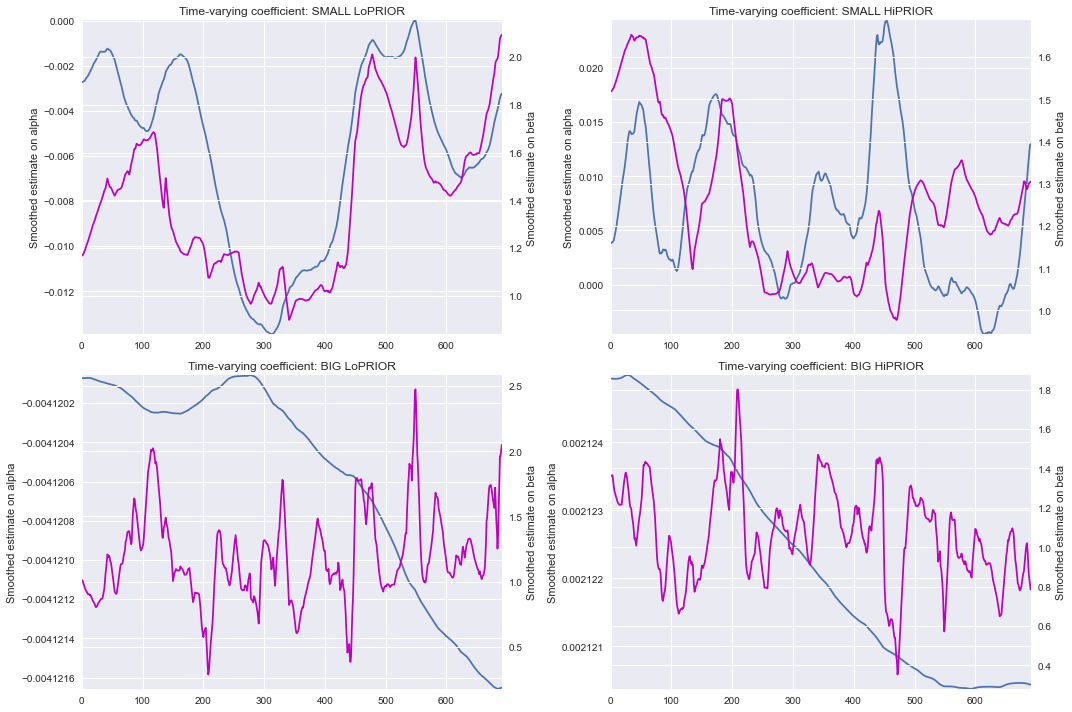

In [18]:
# CAPM
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for i in range(4):
    y = df_corner.iloc[:, i:i+1].values - df_corner.iloc[:, -1:].values
    X = sm.add_constant(df_corner['Mkt-RF'].values)
    mod = KalmanFilter(y, X)
    res = mod.fit()

    print(res.summary())
    ss = pd.DataFrame(res.smoothed_state.T, columns=['alpha', 'beta'])

    axes[i//2][i%2].plot(ss['alpha'])
    axes[i//2][i%2].set_ylabel("Smoothed estimate on alpha")
    ax2 = axes[i//2][i%2].twinx()
    ax2.set_ylabel('Smoothed estimate on beta')
    ax2.plot(ss['beta'], color='m')
    axes[i//2][i%2].set_title(f'Time-varying coefficient: {df_corner.columns[i]}')
    axes[i//2][i%2].autoscale(tight=True)
fig.tight_layout();